In [152]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, coint
from datetime import datetime, timedelta
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [119]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
price_df = feather.read_feather('data\\91_coin_price.feather')
volume_df = feather.read_feather('data\\91_coin_volume.feather')

In [9]:
n_cols = [i[4:] for i in price_df.columns]

In [10]:
price_df.columns = n_cols
volume_df.columns = n_cols

In [132]:
volume_df.sum().sort_values(ascending=False).head(10)

BTC    131517203059590.71875
XRP     98854508885164.68750
SOL     53138719448687.10156
DOGE    45987918999275.82812
ETC     37530292699133.97656
ETH     37373210414715.83594
STX     37042913963910.07812
APT     27985444037772.73047
BCH     24496056818023.52734
GAS     24304903508824.66797
dtype: float64

In [134]:
top6_volume_coins = ['BTC', 'XRP', 'SOL', 'DOGE', 'ETC', 'ETH']

In [135]:
top6_df = price_df[top6_volume_coins]

In [137]:
btc_price = price_df['BTC']
xrp_price = price_df['XRP']
sol_price = price_df['SOL']
doge_price = price_df['DOGE']
etc_price = price_df['ETC']
eth_price = price_df['ETH']

# 15분
btc_15m_price = btc_price.resample('15T').agg({'BTC':'last'})
xrp_15m_price = xrp_price.resample('15T').agg({'XRP':'last'})
sol_15m_price = sol_price.resample('15T').agg({'SOL':'last'})
doge_15m_price = doge_price.resample('15T').agg({'DOGE':'last'})
etc_15m_price = etc_price.resample('15T').agg({'ETC':'last'})
eth_15m_price = eth_price.resample('15T').agg({'ETH':'last'})
all_15m_list = [btc_15m_price, xrp_15m_price, sol_15m_price, doge_15m_price, etc_15m_price, eth_15m_price]

# 1시간
btc_1h_price = btc_price.resample('1H').agg({'BTC':'last'})
xrp_1h_price = xrp_price.resample('1H').agg({'XRP':'last'})
sol_1h_price = sol_price.resample('1H').agg({'SOL':'last'})
doge_1h_price = doge_price.resample('1H').agg({'DOGE':'last'})
etc_1h_price = etc_price.resample('1H').agg({'ETC':'last'})
eth_1h_price = eth_price.resample('1H').agg({'ETH':'last'})
all_1h_list = [btc_1h_price, xrp_1h_price, sol_1h_price, doge_1h_price, etc_1h_price, eth_1h_price]

# 4시간
btc_4h_price = btc_price.resample('4H').agg({'BTC':'last'})
xrp_4h_price = xrp_price.resample('4H').agg({'XRP':'last'})
sol_4h_price = sol_price.resample('4H').agg({'SOL':'last'})
doge_4h_price = doge_price.resample('4H').agg({'DOGE':'last'})
etc_4h_price = etc_price.resample('4H').agg({'ETC':'last'})
eth_4h_price = eth_price.resample('4H').agg({'ETH':'last'})
all_4h_list = [btc_4h_price, xrp_4h_price, sol_4h_price, doge_4h_price, etc_4h_price, eth_4h_price]

# 6시간
btc_6h_price = btc_price.resample('6H').agg({'BTC':'last'})
xrp_6h_price = xrp_price.resample('6H').agg({'XRP':'last'})
sol_6h_price = sol_price.resample('6H').agg({'SOL':'last'})
doge_6h_price = doge_price.resample('6H').agg({'DOGE':'last'})
etc_6h_price = etc_price.resample('6H').agg({'ETC':'last'})
eth_6h_price = eth_price.resample('6H').agg({'ETH':'last'})
all_6h_list = [btc_6h_price, xrp_6h_price, sol_6h_price, doge_6h_price, etc_6h_price, eth_6h_price]

# 12시간
btc_12h_price = btc_price.resample('12H').agg({'BTC':'last'})
xrp_12h_price = xrp_price.resample('12H').agg({'XRP':'last'})
sol_12h_price = sol_price.resample('12H').agg({'SOL':'last'})
doge_12h_price = doge_price.resample('12H').agg({'DOGE':'last'})
etc_12h_price = etc_price.resample('12H').agg({'ETC':'last'})
eth_12h_price = eth_price.resample('12H').agg({'ETH':'last'})
all_12h_list = [btc_12h_price, xrp_12h_price, sol_12h_price, doge_12h_price, etc_12h_price, eth_12h_price]

# 일봉
btc_1d_price = btc_price.resample('1D').agg({'BTC':'last'})
xrp_1d_price = xrp_price.resample('1D').agg({'XRP':'last'})
sol_1d_price = sol_price.resample('1D').agg({'SOL':'last'})
doge_1d_price = doge_price.resample('1D').agg({'DOGE':'last'})
etc_1d_price = etc_price.resample('1D').agg({'ETC':'last'})
eth_1d_price = eth_price.resample('1D').agg({'ETH':'last'})
all_1d_list = [btc_1d_price, xrp_1d_price, sol_1d_price, doge_1d_price, etc_1d_price, eth_1d_price]

# 주봉
btc_1w_price = btc_price.resample('1W').agg({'BTC':'last'})
xrp_1w_price = xrp_price.resample('1W').agg({'XRP':'last'})
sol_1w_price = sol_price.resample('1W').agg({'SOL':'last'})
doge_1w_price = doge_price.resample('1W').agg({'DOGE':'last'})
etc_1w_price = etc_price.resample('1W').agg({'ETC':'last'})
eth_1w_price = eth_price.resample('1W').agg({'ETH':'last'})
all_1w_list = [btc_1w_price, xrp_1w_price, sol_1w_price, doge_1w_price, etc_1w_price, eth_1w_price]

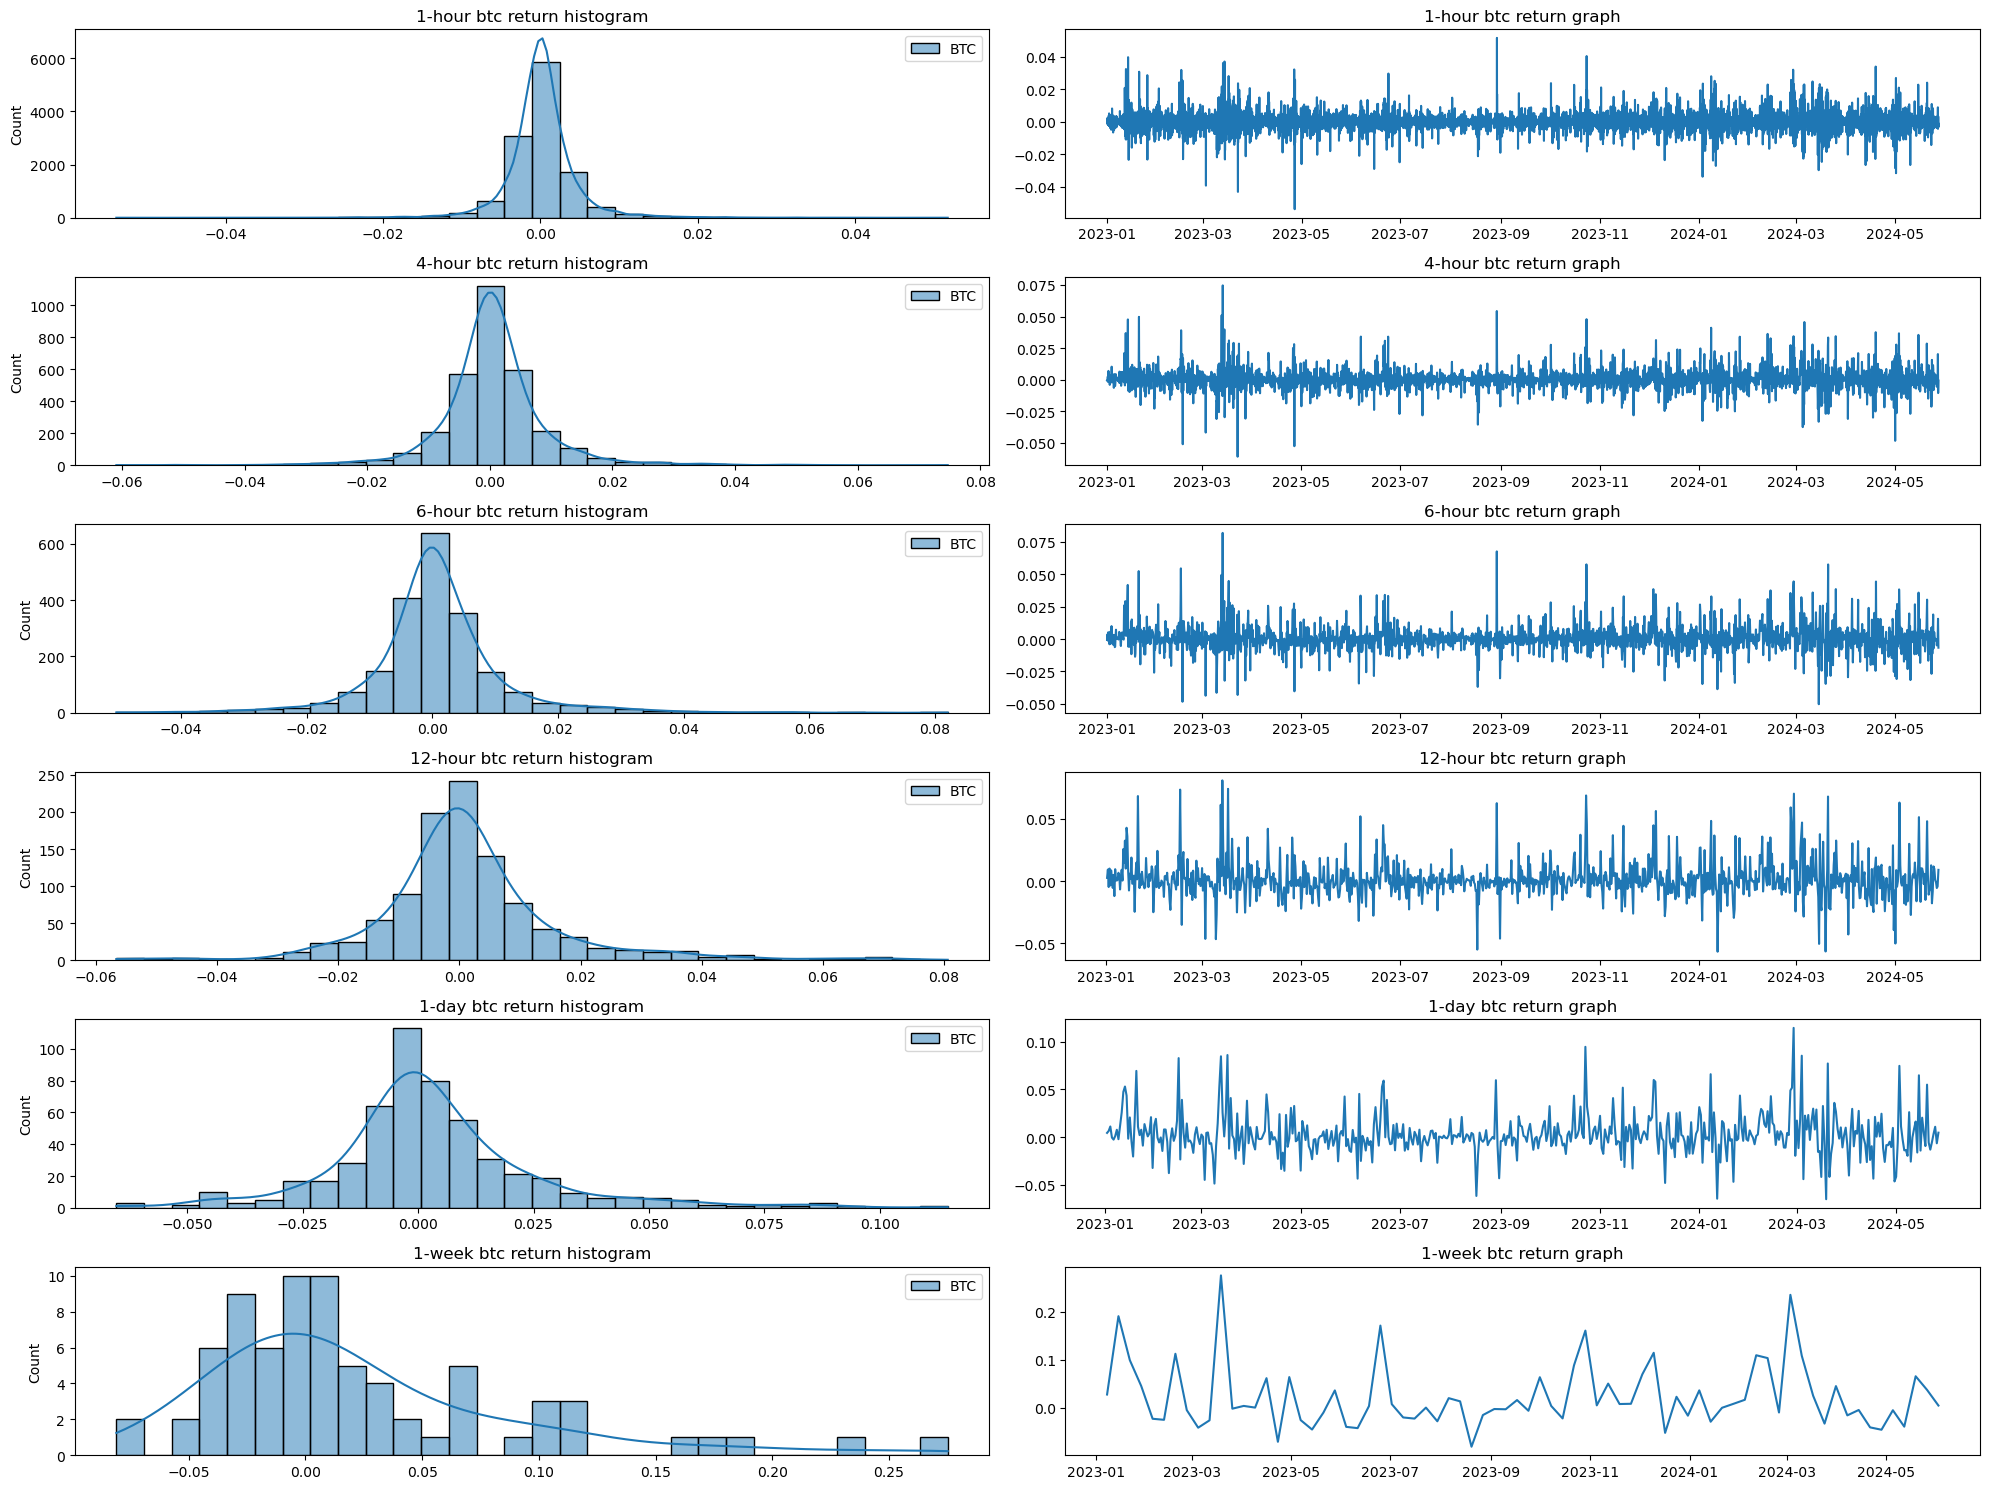

In [130]:
plt.figure(figsize=(20, 15));

plt.subplot(6,2,1)
sns.histplot(btc_1h_price.pct_change(),kde=True, bins=30);
plt.title('1-hour btc return histogram')
plt.subplot(6,2,2)
plt.plot(btc_1h_price.pct_change());
plt.title('1-hour btc return graph')

plt.subplot(6,2,3)
sns.histplot(btc_4h_price.pct_change(),kde=True, bins=30);
plt.title('4-hour btc return histogram')
plt.subplot(6,2,4)
plt.plot(btc_4h_price.pct_change());
plt.title('4-hour btc return graph')

plt.subplot(6,2,5)
sns.histplot(btc_6h_price.pct_change(),kde=True, bins=30);
plt.title('6-hour btc return histogram')
plt.subplot(6,2,6)
plt.plot(btc_6h_price.pct_change());
plt.title('6-hour btc return graph')

plt.subplot(6,2,7)
sns.histplot(btc_12h_price.pct_change(),kde=True, bins=30);
plt.title('12-hour btc return histogram')
plt.subplot(6,2,8)
plt.plot(btc_12h_price.pct_change());
plt.title('12-hour btc return graph')

plt.subplot(6,2,9)
sns.histplot(btc_1d_price.pct_change(),kde=True, bins=30);
plt.title('1-day btc return histogram')
plt.subplot(6,2,10)
plt.plot(btc_1d_price.pct_change());
plt.title('1-day btc return graph')

plt.subplot(6,2,11)
sns.histplot(btc_1w_price.pct_change(),kde=True, bins=30);
plt.title('1-week btc return histogram')
plt.subplot(6,2,12)
plt.plot(btc_1w_price.pct_change());
plt.title('1-week btc return graph')

plt.tight_layout();

In [138]:
all_time_list =[
    all_15m_list,
    all_1h_list,
    all_4h_list,
    all_6h_list,
    all_12h_list,
    all_1d_list,
    all_1w_list
]

In [146]:
adf_test_statistics = {
    'ADF Statistic': adf_test_result[0],
    'p-value': adf_test_result[1],
    'Critical Values': adf_test_result[4]
}

In [147]:
pd.DataFrame(adf_test_statistics)

,ADF Statistic,p-value,Critical Values
1%,-7.84746,0.00000,-3.52328
10%,-7.84746,0.00000,-2.58837
5%,-7.84746,0.00000,-2.90203


In [145]:
for time_list in all_time_list:
    for coin_df in time_list:
        code = coin_df.columns[0]
        coin_ret_df = coin_df.pct_change().dropna()
        adf_test_result = adfuller(coin_ret_df[code])
        break

In [ ]:
price_1h_df = price_df.resample('1H').agg({code:'last' for code in price_df.columns})

price_1h_corr_df = price_1h_df.corr()

corr_df = price_1h_corr_df.reset_index().melt(id_vars='index', value_vars=price_1h_corr_df.columns)

corr_df.columns =['coin1', 'coin2', 'corr']

corr_df = corr_df[corr_df['corr']!=1].sort_values(by='corr', ascending=False).drop_duplicates(subset='corr')

,coin1,coin2,corr
28,ETH,BTC,0.98284
5965,MANA,SAND,0.97780
6188,BTC,SOL,0.97472
2742,AXS,FLOW,0.96941
1555,AQT,CBK,0.96857
...,...,...,...
4143,LOOM,KAVA,-0.35212
2320,KAVA,ELF,-0.35779
4175,TRX,KAVA,-0.43299
7962,KAVA,XLM,-0.45237
